In [1]:
%load_ext autoreload
%autoreload 2

from pybasilica import run
from pybasilica import svi
import pandas as pd 
import numpy as np
import seaborn as sns
import torch
import pyro
from sklearn.metrics import rand_score, mutual_info_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity 

/Users/elenab/Library/r-miniconda-arm64/envs/signatures/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = "./pybasilica/data/synthetic_data/simul.N100.G5.s23"
data = pd.read_csv(file+"_counts.csv", sep=',')
groups_true = [i-1 for i in data["groups"].values]
data = data.drop(columns=["groups"])
N = data.shape[0] 

In [3]:
beta_fixed_true = ["SBS10b", "SBS1","SBS5","SBS22","SBS12","SBS3"]
beta_denovo_true = ["SBS2", "SBS4", "SBS25", "SBS44", "SBS9", "SBS13", "SBS88"]
k_fixed_true = len(beta_fixed_true)
k_denovo_true = len(beta_denovo_true)

alpha_true = pd.read_csv(file+"_alpha.csv", sep=",")
alpha_true = alpha_true[beta_fixed_true+beta_denovo_true]

In [4]:
catalogue = pd.read_csv("../simbasilica/script_test/COSMIC_v3.3.1_SBS_GRCh38.txt", sep="\t", index_col=0).transpose()

catalogue_fixed = catalogue.loc[beta_fixed_true]
catalogue_denovo = catalogue.loc[beta_denovo_true]

In [5]:
def get_cosine(obj, filt=True):
    beta_est = pd.concat((obj.beta_denovo, obj.beta_fixed))
    beta_est = beta_est.rename(index = lambda x: x + "_E")

    out_cosine = cosine_similarity(np.concatenate((beta_est, catalogue_denovo, catalogue_fixed)))
    names = list(beta_est.index) + beta_denovo_true + beta_fixed_true
    out_cosine = pd.DataFrame(out_cosine, index=names, columns=names) 
    
    if filt:
        out_cosine = out_cosine.loc[list(beta_est.index)][beta_fixed_true+beta_denovo_true]
    
    return out_cosine

In [6]:
def plot_cosine(obj, filt=True): 
    out_cosine = get_cosine(obj, filt=filt)
    
    sns.heatmap(out_cosine, vmin=0., vmax=1., cmap="crest") 

## Run without fixed signatures 
Compare the results with and without known groups as input

In [7]:
x1a = run.fit(data, k_list=k_denovo_true+k_fixed_true, verbose=False) 
x1b = run.fit(data, k_list=k_denovo_true+k_fixed_true, groups=groups_true, verbose=False) 

In [8]:
cosine_a = get_cosine(x1a)
cosine_b = get_cosine(x1b)

In [9]:
print(len(set(cosine_a.transpose().idxmax().values)))
print(len(set(cosine_b.transpose().idxmax().values)))

10
10


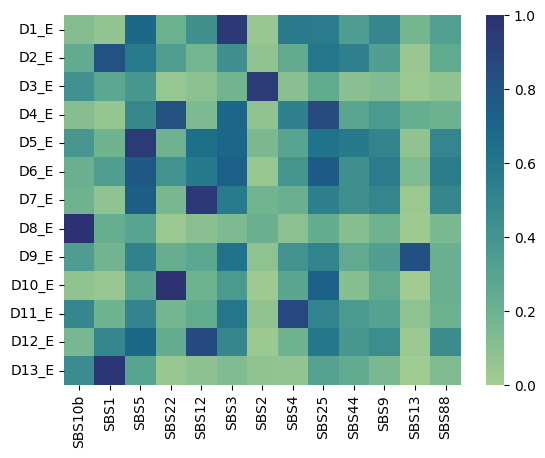

In [10]:
plot_cosine(x1a, filt=True) 

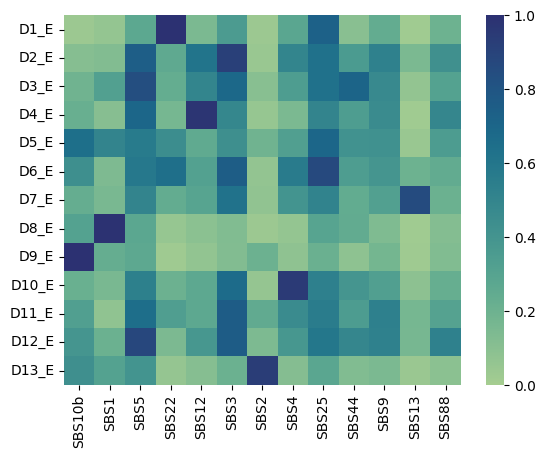

In [11]:
plot_cosine(x1b)

## Run with and fixed catalogue
Compare the results with and without known groups as input.

In [12]:
x2a = run.fit(data, k_list=k_denovo_true, beta_fixed=catalogue_fixed, verbose=False) 
x2b = run.fit(data, k_list=k_denovo_true, groups=groups_true, beta_fixed=catalogue_fixed, verbose=False) 

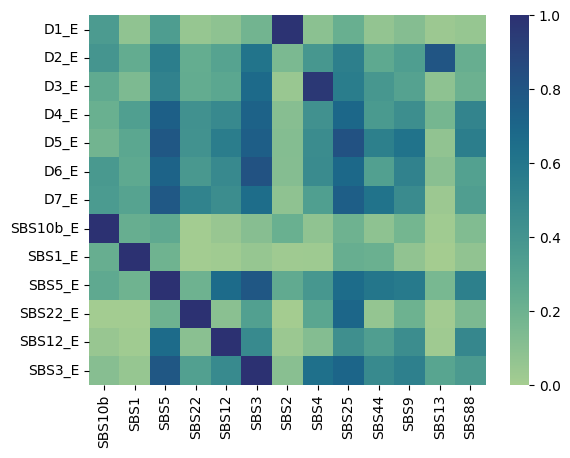

In [13]:
plot_cosine(x2a) 

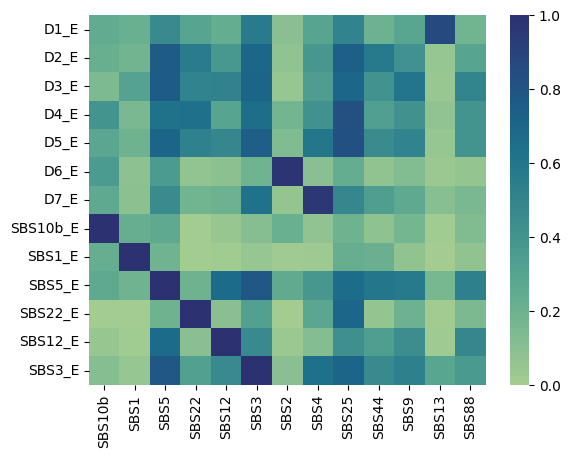

In [14]:
plot_cosine(x2b)

## Run with latent groups

In [15]:
x3a = run.fit(data, k_list=k_denovo_true+k_fixed_true, cluster=5, enumer=False, verbose=False) 
x3b = run.fit(data, k_list=k_denovo_true, cluster=5, beta_fixed=catalogue_fixed, enumer=False, verbose=False) 

GUIDE pi tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000], grad_fn=<ExpandBackward0>)
MODEL pi tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000], grad_fn=<ExpandBackward0>)
GUIDE pi tensor([0.2111, 0.2116, 0.1929, 0.1915, 0.1929], grad_fn=<ExpandBackward0>)
MODEL pi tensor([0.2111, 0.2116, 0.1929, 0.1915, 0.1929], grad_fn=<ExpandBackward0>)
GUIDE pi tensor([0.2022, 0.2166, 0.1991, 0.1830, 0.1991], grad_fn=<ExpandBackward0>)
MODEL pi tensor([0.2022, 0.2166, 0.1991, 0.1830, 0.1991], grad_fn=<ExpandBackward0>)
GUIDE pi tensor([0.1943, 0.2161, 0.2046, 0.1804, 0.2046], grad_fn=<ExpandBackward0>)
MODEL pi tensor([0.1943, 0.2161, 0.2046, 0.1804, 0.2046], grad_fn=<ExpandBackward0>)
GUIDE pi tensor([0.1919, 0.2139, 0.2059, 0.1823, 0.2059], grad_fn=<ExpandBackward0>)
MODEL pi tensor([0.1919, 0.2139, 0.2059, 0.1823, 0.2059], grad_fn=<ExpandBackward0>)
GUIDE pi tensor([0.1936, 0.2113, 0.2043, 0.1866, 0.2043], grad_fn=<ExpandBackward0>)
MODEL pi tensor([0.1936, 0.2113, 0.2043, 0.1866, 0.2043], grad_fn

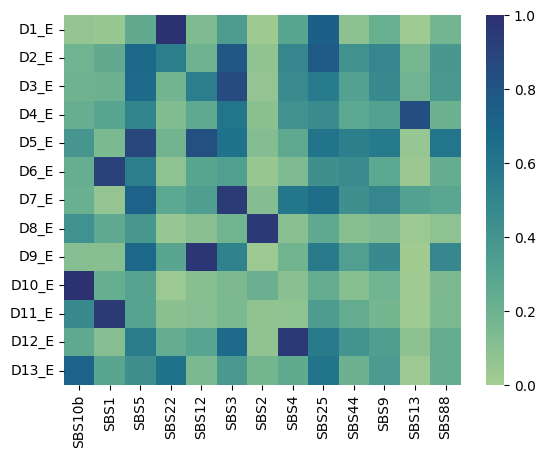

In [16]:
plot_cosine(x3a) 

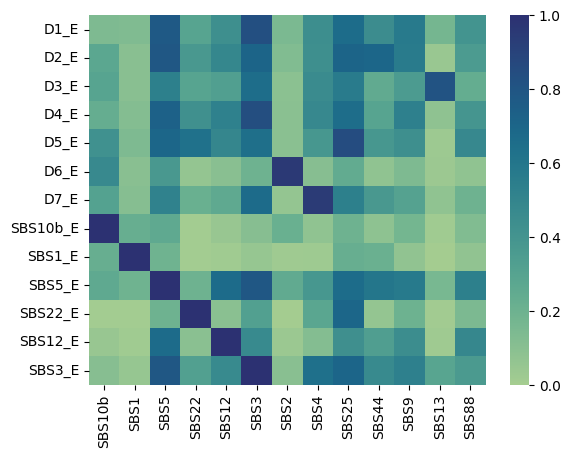

In [17]:
plot_cosine(x3b) 

In [18]:
print(rand_score(groups_true, x3a.z.detach().numpy()))
print(mutual_info_score(groups_true, x3a.z.detach().numpy()))
print(normalized_mutual_info_score(groups_true, x3a.z.detach().numpy())) 

0.6989898989898989
0.21209705401589402
0.13231112510904205


In [19]:
print(rand_score(groups_true, x3b.z.detach().numpy()))
print(mutual_info_score(groups_true, x3b.z.detach().numpy()))
print(normalized_mutual_info_score(groups_true, x3b.z.detach().numpy())) 

0.6767676767676768
0.04713797131585107
0.029567982828098246


## Run with full enumeration

In [25]:
x4a = run.fit(data, k_list=k_denovo_true+k_fixed_true, cluster=5, enumer="sequential", verbose=False) 
x4b = run.fit(data, k_list=k_denovo_true, cluster=5, enumer="sequential", beta_fixed=catalogue_fixed, verbose=False) 

tensor([7.0101e-17, 5.1678e-13, 1.0000e+00, 1.4070e-11, 2.2585e-10],
       grad_fn=<DivBackward0>)
tensor([7.0101e-17, 5.1678e-13, 1.0000e+00, 1.4070e-11, 2.2585e-10],
       grad_fn=<DivBackward0>)
COMPUTING Z PROBS
tensor([2.7755e-15, 3.1142e-09, 1.3574e-13, 1.0000e+00, 6.8768e-11],
       grad_fn=<DivBackward0>)
tensor([2.7755e-15, 3.1142e-09, 1.3574e-13, 1.0000e+00, 6.8768e-11],
       grad_fn=<DivBackward0>)
COMPUTING Z PROBS
tensor([1.0000e+00, 2.0087e-16, 3.7309e-17, 8.2938e-17, 5.0404e-21],
       grad_fn=<DivBackward0>)
tensor([1.0000e+00, 2.0087e-16, 3.7309e-17, 8.2938e-17, 5.0404e-21],
       grad_fn=<DivBackward0>)
COMPUTING Z PROBS
tensor([6.3996e-13, 1.0000e+00, 3.6748e-14, 6.6489e-11, 2.1873e-16],
       grad_fn=<DivBackward0>)
tensor([6.3996e-13, 1.0000e+00, 3.6748e-14, 6.6489e-11, 2.1873e-16],
       grad_fn=<DivBackward0>)
COMPUTING Z PROBS
tensor([1.4020e-15, 6.2983e-17, 1.0000e+00, 1.5384e-17, 2.7146e-18],
       grad_fn=<DivBackward0>)
tensor([1.4020e-15, 6.2983e-

In [ ]:
np.bincount(groups_true) / 100 

array([0.16, 0.25, 0.22, 0.19, 0.18])

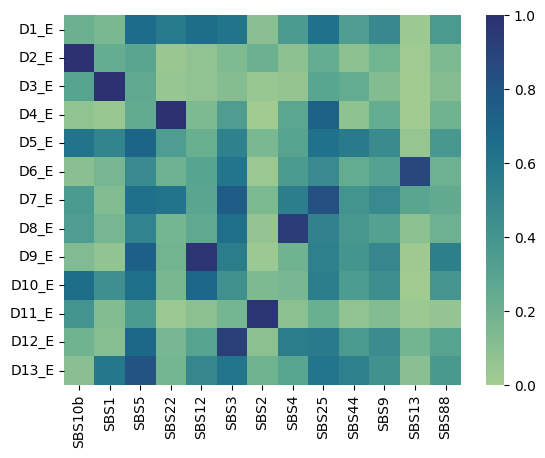

In [ ]:
plot_cosine(x4a) 

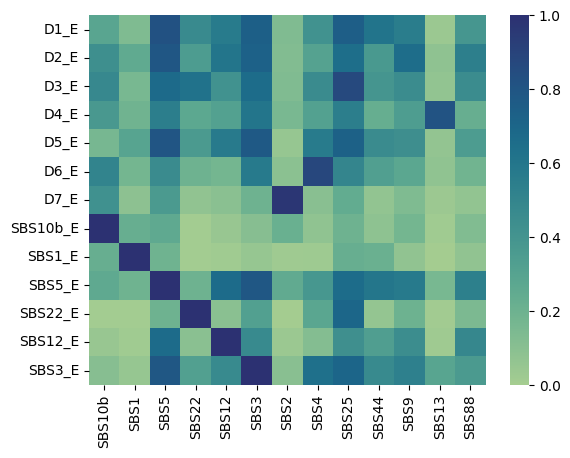

In [ ]:
plot_cosine(x4b)

In [ ]:
z_a = x4a.z 
z_b = x4b.z 

In [ ]:
z_a2 = compute_posterior_probs(x4a)

In [ ]:
z_a

tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [ ]:
x4a.pi

tensor([0.2300, 0.1100, 0.2100, 0.2300, 0.2200])

In [ ]:
z_a2

tensor([4., 4., 0., 1., 4., 3., 3., 3., 3., 3., 3., 3., 1., 3., 4., 4., 4., 1.,
        3., 4., 4., 0., 2., 0., 0., 4., 0., 3., 0., 3., 0., 0., 0., 2., 0., 0.,
        2., 2., 0., 0., 3., 3., 0., 0., 0., 0., 2., 0., 3., 3., 3., 3., 3., 3.,
        3., 3., 0., 0., 3., 3., 0., 3., 3., 3., 3., 3., 4., 0., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 0., 4., 4., 4., 4., 4., 0., 0., 0., 4., 4., 0., 4.,
        4., 4., 0., 4., 4., 0., 0., 0., 4., 4.])

In [ ]:
print("Model with no beta_fixed - ", rand_score(groups_true, z_a), ". Model with beta_fixed - ", rand_score(groups_true, z_a)) 
print("Model with no beta_fixed - ", normalized_mutual_info_score(groups_true, z_a), ". Model with beta_fixed - ", normalized_mutual_info_score(groups_true, z_b)) 

Model with no beta_fixed -  0.19696969696969696 . Model with beta_fixed -  0.19696969696969696


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
sns.displot([float(pyro.distributions.HalfNormal(.2).sample()) for _ in range(1000)])

In [ ]:
def _logsumexp(weighted_lp) -> torch.Tensor:
    '''
    Returns `m + log( sum( exp( weighted_lp - m ) ) )`
    - `m` is the the maximum value of weighted_lp for each observation among the K values
    - `torch.exp(weighted_lp - m)` to perform some sort of normalization
    In this way the `exp` for the maximum value will be exp(0)=1, while for the 
    others will be lower than 1, thus the sum across the K components will sum up to 1.
    '''
    m = torch.amax(weighted_lp, dim=0)  # the maximum value for each observation among the K values
    summed_lk = m + torch.log(torch.sum(torch.exp(weighted_lp - m), axis=0))
    return summed_lk 

def get_params(x):
    params = dict()
    params["alpha"] = x.alpha
    params["alpha_prior"] = x.alpha_prior

    params["beta_d"] = x.beta_denovo
    params["beta_f"] = x.beta_fixed

    params["pi"] = x.pi

    return params

def compute_posterior_probs(x):
    params = get_params(x)
    M = torch.tensor(x.x.values)
    cluster = x.cluster
    n_samples = x.n_samples
    
    # not necesary since already normalised
    # alpha_prior = x4.alpha_prior / (torch.sum(x4.alpha_prior, 1).unsqueeze(-1))
    try:
        beta = torch.cat((torch.tensor(params["beta_f"].values), torch.tensor(params["beta_d"].values)), axis=0) 
    except:
        beta = torch.tensor(params["beta_d"].values)
    
    z = torch.zeros(n_samples)

    for n in range(n_samples):
        m_n = M[n,:].unsqueeze(0)
        ll_nk = torch.zeros((cluster, M.shape[1]))

        for k in range(cluster):
            muts_n = torch.sum(m_n, axis=1).float()  # muts for patient n
            rate = torch.matmul( \
                torch.matmul( torch.diag(muts_n), params["alpha_prior"][k,:].unsqueeze(0) ), \
                beta.float() )
            
            # compute weighted log probability
            ll_nk[k,:] = torch.log(params["pi"][k]) + pyro.distributions.Poisson( rate ).log_prob(m_n) 

        ll_nk_sum = ll_nk.sum(axis=1)  # sum over the contexts -> reaches a tensor of shape (n_clusters)
        ll = _logsumexp(ll_nk_sum)
        probs = torch.exp(ll_nk_sum - ll)

        best_cl = torch.argmax(probs)
        z[n] = best_cl 

    return z